# `bindsnet` ETH replication

In [1]:
import os
import sys
import torch
import timeit
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet', 'network')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet', 'datasets')))

from datasets    import MNIST
from network     import Network
from encoding    import get_poisson
from connections import Connection, post_pre
from nodes       import AdaptiveLIFNodes, LIFNodes, Input

%matplotlib inline

## Build network

In [2]:
network = Network(dt=1.0)

In [3]:
n = 100; n_sqrt = int(np.sqrt(n))

input_layer = Input(n=784, traces=True, trace_tc=1 / 20)
exc_layer = AdaptiveLIFNodes(n=n, traces=True, rest=-65.0, reset=-65.0, threshold=-52.0, refractory=5,
                                    voltage_decay=1e-2, trace_tc=1 / 20, theta_plus=0.05, theta_decay=1e-7)
inh_layer = LIFNodes(n=n, traces=False, rest=-60.0, reset=-45.0, threshold=-40.0,
                                 voltage_decay=1e-1, refractory=2, trace_tc=1 / 20)

w = 0.3 * torch.rand(input_layer.n, exc_layer.n)
input_exc_conn = Connection(source=input_layer, target=exc_layer, w=w,
                            update_rule=post_pre, wmin=0.0, wmax=1.0)

w = 22.5 * torch.diag(torch.ones(exc_layer.n))
exc_inh_conn = Connection(source=exc_layer, target=inh_layer, w=w, update_rule=None)

w = -17.5 * (torch.ones(inh_layer.n, exc_layer.n) - torch.diag(torch.ones(inh_layer.n)))
inh_exc_conn = Connection(source=inh_layer, target=exc_layer, w=w, update_rule=None)

In [4]:
network.add_layer(input_layer, name='X')
network.add_layer(exc_layer, name='Ae')
network.add_layer(inh_layer, name='Ai')

network.add_connection(input_exc_conn, source='X', target='Ae')
network.add_connection(exc_inh_conn, source='Ae', target='Ai')
network.add_connection(inh_exc_conn, source='Ai', target='Ae')

## Load MNIST data

In [5]:
images, labels = MNIST(path='../../data').get_train()

Loading training images from serialized object file.

Loading labels from serialized object file.



In [6]:
print('Training images shape', images.size())
print('Training labels shape', labels.size())

Training images shape torch.Size([60000, 28, 28])
Training labels shape torch.Size([60000])


## Encode MNIST images as Poisson spike trains

In [7]:
time = 350
data_loader = get_poisson(data=images, time=time)

## Train the network

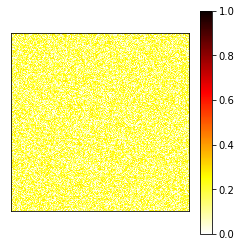

In [8]:
weights = network.connections[('X', 'Ae')].w

to_plot = np.zeros([28 * n_sqrt, 28 * n_sqrt])
for i in range(n_sqrt):
    for j in range(n_sqrt):
        filter_ = weights[:, i * n_sqrt + j].numpy().reshape([28, 28])
        to_plot[i * 28 : (i + 1) * 28, (j % n_sqrt) * 28 : ((j % n_sqrt) + 1) * 28] = filter_
                        
plt.matshow(to_plot, cmap='hot_r', vmin=0, vmax=1);
plt.xticks(()); plt.yticks(());
plt.colorbar();

In [9]:
n_train = 50

for i in range(n_train):
    sample = next(data_loader)
    inpts = {'X' : sample.view(time, -1)}
    
    network.run(inpts=inpts, time=time)
    network.connections[('X', 'Ae')].normalize()

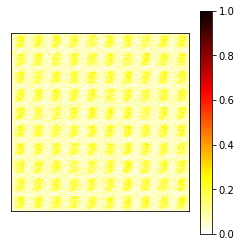

In [10]:
weights = network.connections[('X', 'Ae')].w

to_plot = np.zeros([28 * n_sqrt, 28 * n_sqrt])
for i in range(n_sqrt):
    for j in range(n_sqrt):
        filter_ = weights[:, i * n_sqrt + j].numpy().reshape([28, 28])
        to_plot[i * 28 : (i + 1) * 28, (j % n_sqrt) * 28 : ((j % n_sqrt) + 1) * 28] = filter_
                        
plt.matshow(to_plot, cmap='hot_r', vmin=0, vmax=1);
plt.xticks(()); plt.yticks(());
plt.colorbar();